# Part 1: Categorical features

We'll load a lung cancer prediction dataset from [Kaggle](https://www.kaggle.com/datasets/thedevastator/cancer-patients-and-air-pollution-a-new-link?resource=download).

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# this is google collab stuff I need to add to access the files on my gdrive -JU
import os
from google.colab import drive
drive.mount('/content/drive/')
os.chdir("/content/drive/My Drive/NIH_FAES/SPRING_2025/BIO_509_Machine_Learning_Class/Week_3")


df = pd.read_csv("lung_cancer.csv")
display(df)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


,index,Patient Id,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,...,Fatigue,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring,Level
0,0,P1,33,1,2,4,5,4,3,2,...,3,4,2,2,3,1,2,3,4,Low
1,1,P10,17,1,3,1,5,3,4,2,...,1,3,7,8,6,2,1,7,2,Medium
2,2,P100,35,1,4,5,6,5,5,4,...,8,7,9,2,1,4,6,7,2,High
3,3,P1000,37,1,7,7,7,7,6,7,...,4,2,3,1,4,5,6,7,5,High
4,4,P101,46,1,6,8,7,7,7,6,...,3,2,4,1,4,2,4,2,3,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,P995,44,1,6,7,7,7,7,6,...,5,3,2,7,8,2,4,5,3,High
996,996,P996,37,2,6,8,7,7,7,6,...,9,6,5,7,2,4,3,1,4,High
997,997,P997,25,2,4,5,6,5,5,4,...,8,7,9,2,1,4,6,7,2,High
998,998,P998,18,2,6,8,7,7,7,6,...,3,2,4,1,4,2,4,2,3,High


Most of these values are ordinal, so we can leave them as numbers. However, `gender` will not make sense as `1` and `2`, and `Level` is not numeric.

**1. Use a [ColumnTransformer](https://scikit-learn.org/stable/modules/compose.html#column-transformer) with OneHotEncoder to convert *only* the `Gender` and `Level` columns to one-hot features. Store ColumnTransformer in `ct` and the result in `one_hot`.**
- Hint: ColumnTransformer is a *transformer*; it must be fit before it transforms data (though these can happen in the same call!)
- Hint: the `remainder` argument controls what happens to columns that are not transformed.


In [33]:
# YOUR CODE HERE (1)
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder

ct = ColumnTransformer(
    [('onehot', OneHotEncoder(), ['Gender', 'Level'])], remainder='passthrough')
one_hot = ct.fit_transform(df)

In [34]:
display(one_hot)

array([[1.0, 0.0, 0.0, ..., 2, 3, 4],
       [1.0, 0.0, 0.0, ..., 1, 7, 2],
       [1.0, 0.0, 1.0, ..., 6, 7, 2],
       ...,
       [0.0, 1.0, 1.0, ..., 6, 7, 2],
       [0.0, 1.0, 1.0, ..., 4, 2, 3],
       [1.0, 0.0, 1.0, ..., 6, 7, 2]], dtype=object)

Note that the transformed columns will appear first, then the 'remainder' columns. Let's look at the new feature names and order.

In [35]:
print(ct.get_feature_names_out())

['onehot__Gender_1' 'onehot__Gender_2' 'onehot__Level_High'
 'onehot__Level_Low' 'onehot__Level_Medium' 'remainder__index'
 'remainder__Patient Id' 'remainder__Age' 'remainder__Air Pollution'
 'remainder__Alcohol use' 'remainder__Dust Allergy'
 'remainder__OccuPational Hazards' 'remainder__Genetic Risk'
 'remainder__chronic Lung Disease' 'remainder__Balanced Diet'
 'remainder__Obesity' 'remainder__Smoking' 'remainder__Passive Smoker'
 'remainder__Chest Pain' 'remainder__Coughing of Blood'
 'remainder__Fatigue' 'remainder__Weight Loss'
 'remainder__Shortness of Breath' 'remainder__Wheezing'
 'remainder__Swallowing Difficulty' 'remainder__Clubbing of Finger Nails'
 'remainder__Frequent Cold' 'remainder__Dry Cough' 'remainder__Snoring']


# Part 2: Overfit

## Modules and helper functions

In [36]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def plot_decision_boundaries(X, y, model):

    plt.figure(figsize=(6, 6))

    # adapted from https://github.com/tirthajyoti/Machine-Learning-with-Python/blob/master/Utilities/ML-Python-utils.py

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_mgn = (X[:, 0].max() - X[:, 0].min()) * 0.1
    y_mgn = (X[:, 1].max() - X[:, 1].min()) * 0.1

    x_min, x_max = X[:, 0].min() - x_mgn, X[:, 0].max() + x_mgn
    y_min, y_max = X[:, 1].min() - y_mgn, X[:, 1].max() + y_mgn
    # Meshgrid creation
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh using the model.
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    x_min, x_max = X[:, 0].min() - x_mgn, X[:, 0].max() + x_mgn
    y_min, y_max = X[:, 1].min() - y_mgn, X[:, 1].max() + y_mgn
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Predictions to obtain the classification results
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Plotting
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8, edgecolor="k")
    plt.show()

np.random.seed(0) # ensure consistent results


## Data
We'll just use two dimensions, `mean radius` and `mean texture`, from the breast cancer dataset so we can visualize the results.

In [37]:
(data, labels) = load_breast_cancer(return_X_y=True, as_frame=True)
var1 = 'mean radius'
var2 = 'mean texture'
X = data[[var1, var2]].to_numpy()
y = labels
ss = StandardScaler()
X = ss.fit_transform(X)

**2. Use the Scikit-Learn `train_test_split()` function to split X and y into train and test sets, with 80% of the data as the training set, and store in `X_train`, `X_test`, `y_train`, `y_test`.**
  - Hint: check out the examples in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).
  - Hint: look at the arguments `test_size` and `train_size`.

In [38]:
# YOUR CODE HERE (2)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

Let's plot just the training data.

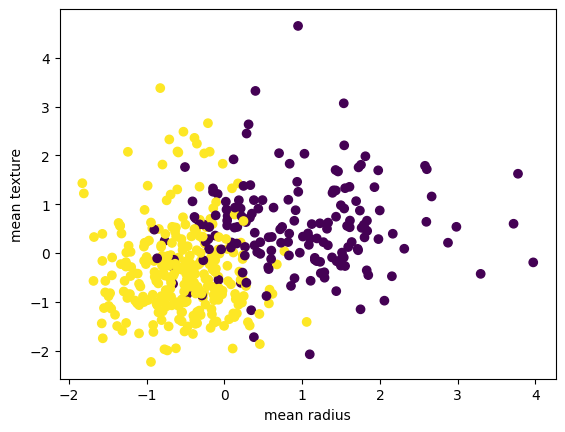

In [39]:
plt.scatter(X_train[:,0], X_train[:,1], c=y_train)
plt.xlabel(var1)
plt.ylabel(var2)
plt.show()

## Training

We'll use a simple classifier called K-Nearest Neighbors, which bases predictions on labels of the nearest training points. The number of neighbors considered can be chosen and is an example of a hyperparameter.

**3. Fit a [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) model that uses only 1 neigbor to the *training* data. Store the model in `knn`. Remember to import the module!**

In [40]:
# YOUR CODE HERE (3)
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

Let's visualize the decision boundary. This plot shows what prediction would be made for every part of the background.

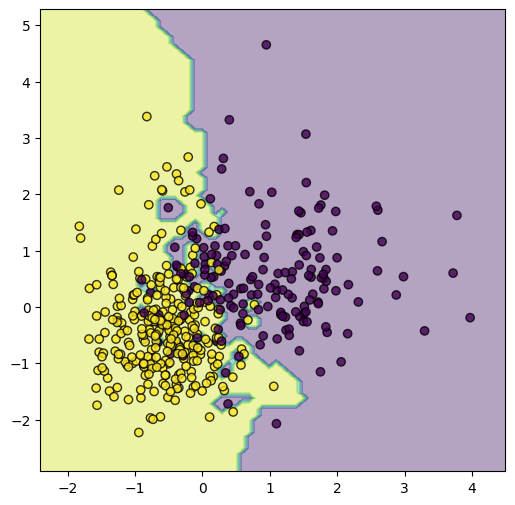

In [41]:
plot_decision_boundaries(X_train, y_train, knn)

The model appears to fit the training data well. Let's evaluate.

## Evaluating

**4. Print the accuracy of the trained model on the training data itself.**
- Hint: Predict labels for the training data using the `predict()` function of the model.
- Hint: Get the accuracy of the trained model on the training data itself using [`accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score).

In [42]:
# YOUR CODE HERE (4)
from sklearn.metrics import accuracy_score
y_pred = knn.predict(X_train) # we use our module (knn) to predict and learn from the training data (X_train)
accuracy_score(y_train, y_pred) # predict y values using X_train data using modeule knn

1.0

We achieved perfect accuracy on the training data. Does that mean this is a good classifier? Let's try the held out test data.

**5. Predict labels for the *test* data, store in `y_hat`, and print the accuracy for the test data.**

In [43]:
# YOUR CODE HERE (5)
y_hat = knn.predict(X_test)
accuracy_score(y_test, y_hat)

0.8947368421052632

The accuracy on the test set (which is what we really care about) is much lower. This is a sign of overfit. Let's see how our test data overlay on the decision boundary we learned.

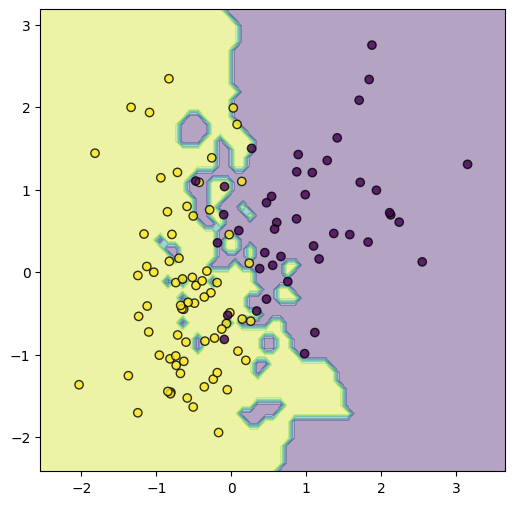

In [44]:
plot_decision_boundaries(X_test, y_test, knn)

We can see how fitting the training data perfectly has decreased the model's ability to generalize to new data.

## Tuning

In this case we can reduce the overfit by adjusting hyperparameters, specifically the number of neighbors considered. Considering more neigbors in each classification smooths out the decision boundary, increasing the bias, but decreasing the variance.

**6. Set the number of neighbors to consider to 5. Fit the model to the training data again.**

In [45]:
# YOUR CODE HERE (6)
# same code as (3)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

**7. Get predicitons for the training data and print the accuracy again.**

In [46]:
# YOUR CODE HERE (7)
# YOUR CODE HERE (4) # same code as (4)
from sklearn.metrics import accuracy_score
y_pred = knn.predict(X_train) # we use our module (knn) to predict and learn from the training data (X_train)
accuracy_score(y_train, y_pred) # predict y values using X_train data using modeule knn

0.9054945054945055

The training accuracy is now lower. Let's look at the test data.

**8. Get predicitons for the test data and print the accuracy again.**

In [47]:
# YOUR CODE HERE (8) -- same code as (5)
y_hat = knn.predict(X_test)
accuracy_score(y_test, y_hat)

0.9035087719298246

The test accuracy has improved! Let's see how the test data look on the new, smoother decision boundary.

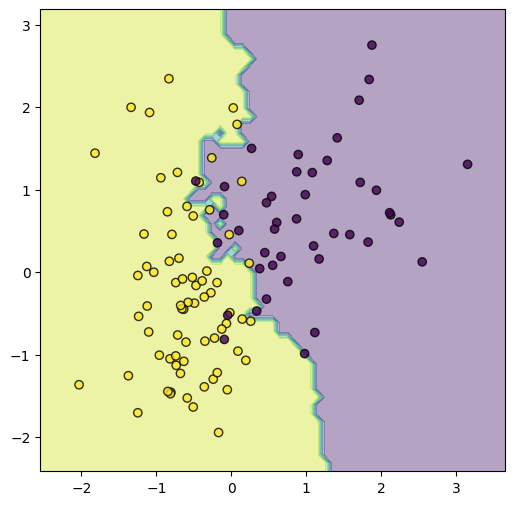

In [48]:
plot_decision_boundaries(X_test, y_test, knn)